In [24]:
# libraries
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import wordnet
import regex as re
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import graphviz
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import scipy.spatial
from scipy.stats import mode
import nltk
import string
import ast
from nltk.corpus import wordnet
from nltk.corpus import sentiwordnet as swn
from wordcloud import WordCloud

# Sklearn imports
from sklearn.datasets import make_classification, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from nltk.corpus import stopwords
from sklearn.neural_network import MLPClassifier

In [2]:
def tf_idf(df_train, df_test):
    vectorizer = TfidfVectorizer(stop_words='english')
    X_train = vectorizer.fit_transform(df_train['token_no_punc'])

    # Transform the testing set using the fitted vectorizer
    X_test = vectorizer.transform(df_test['token_no_punc'])
    return X_train, X_test, vectorizer

def bags_of_words(df_train, df_test):
    vectorizer = CountVectorizer(stop_words='english')
    X_train = vectorizer.fit_transform(df_train['token_no_punc'])

    # Transform the testing set using the fitted vectorizer
    X_test = vectorizer.transform(df_test['token_no_punc'])
    return X_train, X_test, vectorizer

def find_optimal_k(x_train, y_train, x_test, y_test):
    ch2_result = []
    chi2score = chi2(x_train, y_train)[0]
    options = np.arange(100000,x_train.shape[1],100000)
    for n in options:
        ch2 = SelectKBest(chi2, k=n)
        x_train_chi2_selected = ch2.fit_transform(x_train, y_train)
        x_test_chi2_selected = ch2.transform(x_test)
        clf = LinearSVC(class_weight='balanced', multi_class='ovr', random_state=42)
        clf.fit(x_train_chi2_selected, y_train)
        score = clf.score(x_test_chi2_selected, y_test)
        ch2_result.append(score)
    return options[np.argmax(ch2_result)]
def grid_search_randomforest(X, y):
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 20)]
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'bootstrap': bootstrap}
    rf = RandomForestClassifier(class_weight='balanced')
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 8, cv = 4, verbose=2, random_state=42)
    rf_random.fit(X, y)
    return rf_random.best_params_
def grid_search_multinomialNB(X, y):
    model=MultinomialNB()
    parameters = {'alpha': [0.0001, 0.001, 0.1, 1, 10, 100]}
    clf=GridSearchCV(model,parameters,cv=4,verbose=0, return_train_score=True)
    clf.fit(X, y)
    return clf.best_params_

def grid_search_SVC(X, y):
    clf_linear_svc_grid = LinearSVC(class_weight='balanced', multi_class='ovr', random_state=42)
    gsc_linear_svc = RandomizedSearchCV(
    estimator=clf_linear_svc_grid,
    param_distributions={
        'C': [10e-1, 10e-2, 1, 10],
        'tol': [10e-3, 10e-2, 10e-1, 10e-0, 10e+1],
    },
    n_iter = 8,
    cv=3,
    verbose=0
    )
    grid_result_linear_svc = gsc_linear_svc.fit(X, y)
    best_hyper = gsc_linear_svc.best_params_
    return best_hyper
def split_x_y_train_test_per_topic(i, topic, df):
    df_partial = df[df['source']==topics[i]]
    df_train, df_test = train_test_split(df_partial, test_size=0.2, random_state=0)
    encoder = OneHotEncoder()
    one_hot_data = encoder.fit(df_train['sentiment'].values.reshape(-1, 1))
    y_train = encoder.transform(df_train['sentiment'].values.reshape(-1, 1)).toarray()
    y_test =  encoder.transform(df_test['sentiment'].values.reshape(-1, 1)).toarray()
    y_train_1d = np.argmax(y_train, axis=1)
    y_test_1d = np.argmax(y_test, axis=1)
    tvec = TfidfVectorizer(ngram_range=(1, 2))
    x_train = tvec.fit_transform(df_train['token_no_punc'])
    x_test = tvec.transform(df_test['token_no_punc'])
    mapping = dict(zip(range(len(encoder.categories_[0])), encoder.categories_[0]))
    return x_train, x_test, y_train, y_test, y_train_1d, y_test_1d, tvec, mapping
def total_split (df):
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)
    encoder = OneHotEncoder()
    one_hot_data = encoder.fit(df_train['source'].values.reshape(-1, 1))
    y_train = encoder.transform(df_train['source'].values.reshape(-1, 1)).toarray()
    y_test =  encoder.transform(df_test['source'].values.reshape(-1, 1)).toarray()
    mapping = dict(zip(range(len(encoder.categories_[0])), encoder.categories_[0]))
    tvec = TfidfVectorizer(ngram_range=(1, 2))
    x_train = tvec.fit_transform(df_train['token_no_punc'])
    x_test = tvec.transform(df_test['token_no_punc'])
    y_train_1d = np.argmax(y_train, axis=1)
    y_test_1d = np.argmax(y_test, axis=1)
    return x_train, y_train_1d, x_test, y_test_1d, df_train, df_test

In [23]:
df = pd.read_csv("sentiment_soup.csv")

In [25]:
df

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,text,source,sentiment,clean_text,tokens_with_punc,lemmatized_tokens,lemma_pos,token_no_punc,language,sentiment_score
0,0,0,0,0,0,listing to music while putting the finishing t...,tweets,positive,listing to music while putting the finishing t...,"['listing', 'to', 'music', 'while', 'putting',...","['list', 'to', 'music', 'while', 'put', 'the',...","[('list', 'v'), ('to', 'n'), ('music', 'n'), (...","['list', 'to', 'music', 'while', 'put', 'the',...",en,0.004808
1,1,1,1,1,1,welcome to the family new pillow im going to ...,tweets,positive,welcome to the family new pillow im going to ...,"['welcome', 'to', 'the', 'family', 'new', 'pil...","['welcome', 'to', 'the', 'family', 'new', 'pil...","[('welcome', 'n'), ('to', 'n'), ('the', 'n'), ...","['welcome', 'to', 'the', 'family', 'new', 'pil...",en,0.034722
2,2,2,2,2,2,Their salad is my favorite! Mmmmmmm...,yelp,positive,their salad is my favorite! mmmmmmm...,"['their', 'salad', 'is', 'my', 'favorite', '!'...","['their', 'salad', 'be', 'my', 'favorite', '!'...","[('their', 'n'), ('salad', 'n'), ('be', 'v'), ...","['their', 'salad', 'be', 'my', 'favorite', 'mm...",en,0.031250
3,3,3,3,3,3,BAC Out 11.78 waiting for a pullback.. if we h...,stock,positive,bac out 11.78 waiting for a pullback.. if we h...,"['bac', 'out', '11.78', 'waiting', 'for', 'a',...","['bac', 'out', '11.78', 'wait', 'for', 'a', 'p...","[('bac', 'n'), ('out', 'r'), ('11.78', 'n'), (...","['bac', 'out', '11.78', 'wait', 'for', 'a', 'p...",en,0.025000
4,4,4,4,4,4,RT @darionavarro111: Simplicity for the simple...,climate,neutral,rt @darionavarro111: simplicity for the simple...,"['rt', '@darionavarro111', ':', 'simplicity', ...","['rt', '@darionavarro111', ':', 'simplicity', ...","[('rt', 'n'), ('@darionavarro111', 'n'), (':',...","['rt', '@darionavarro111', 'simplicity', 'for'...",en,0.010417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97266,97266,97266,99994,99995,99995,I am very interested in animal children and I ...,movies,negative,i am very interested in animal children and i ...,"['i', 'am', 'very', 'interested', 'in', 'anima...","['i', 'be', 'very', 'interested', 'in', 'anima...","[('i', 'n'), ('be', 'v'), ('very', 'r'), ('int...","['i', 'be', 'very', 'interested', 'in', 'anima...",en,-0.011864
97267,97267,97267,99995,99996,99996,: i know i*m late but i didn`t had internet....,tweets,neutral,: i know i*m late but i didn`t had internet....,"[':', 'i', 'know', 'i', '*', 'm', 'late', 'but...","[':', 'i', 'know', 'i', '*', 'm', 'late', 'but...","[(':', 'n'), ('i', 'n'), ('know', 'v'), ('i', ...","['i', 'know', 'i', 'm', 'late', 'but', 'i', 'd...",en,0.038043
97268,97268,97268,99996,99997,99997,I can't wait to visit my parents in Vegas agai...,yelp,positive,i can't wait to visit my parents in vegas agai...,"['i', ""can't"", 'wait', 'to', 'visit', 'my', 'p...","['i', ""can't"", 'wait', 'to', 'visit', 'my', 'p...","[('i', 'n'), (""can't"", 'v'), ('wait', 'n'), ('...","['i', ""can't"", 'wait', 'to', 'visit', 'my', 'p...",en,0.031746
97269,97269,97269,99997,99998,99998,"Very nice setup, great food and service And ve...",yelp,positive,"very nice setup, great food and service and ve...","['very', 'nice', 'setup', ',', 'great', 'food'...","['very', 'nice', 'setup', ',', 'great', 'food'...","[('very', 'r'), ('nice', 'a'), ('setup', 'n'),...","['very', 'nice', 'setup', 'great', 'food', 'an...",en,0.105769


# Preprocessing

In [3]:
# Helper functions
# Define a function to lemmatize a list of tokens
def concatenate_to_string(l):
    list_tokens = ast.literal_eval(l)
    str_ = ' '.join(list_tokens)
    return str_

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Define a function to convert POS tags to WordNet POS tags
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
    
# Define a function to tokenize, POS tag, and lemmatize a list of tokens
def tokenize_pos_lemmatize(tokens):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    pos_tags = nltk.pos_tag(tokens)
    lemmas = []
    lemma_pos = []
    for token, pos_tag in pos_tags:
        wordnet_pos = get_wordnet_pos(pos_tag)
        lemma = lemmatizer.lemmatize(token, pos=wordnet_pos)
        lemmas.append(lemma)
        lemma_pos.append((lemma, wordnet_pos))
    return lemmas, lemma_pos

def remove_punctuation(word_list):
    PUNCUATION_LIST = list(string.punctuation)
    """Remove punctuation tokens from a list of tokens"""
    return [w for w in word_list if w not in PUNCUATION_LIST]

import ast
from nltk.corpus import sentiwordnet as swn
# Define a function to calculate the sentiment score for a given word and POS tag
def get_sentiment(word, pos_tag):
    synsets = list(swn.senti_synsets(word, pos_tag))
    if not synsets:
        return 0.0
    else:
        return synsets[0].pos_score() - synsets[0].neg_score()
def calculate_sentiment(lemma_with_pos):
    lemma_with_pos = ast.literal_eval(lemma_with_pos)
    sentiments = [get_sentiment(word, pos) for word, pos in lemma_with_pos]
    if sentiments:
        return sum(sentiments) / len(sentiments)
    else:
        return 0.0

In [4]:
def preprocess(df):
    df = df.drop_duplicates(subset=['text'])
    df = df.dropna(subset=['text'], inplace=True)
    df['clean_text']=df['text'].str.lower()
    df['clean_text'] = df.clean_text.apply(lambda x: re.sub(r"https?\S+", '', x))
    tknzr = TweetTokenizer()
    df['tokens_with_punc'] = df['clean_text'].apply(tknzr.tokenize)
    df[['lemmatized_tokens', 'lemma_pos']] = df['tokens_with_punc'].apply(lambda x: pd.Series(tokenize_pos_lemmatize(x)))
    df['token_no_punc'] = df['lemmatized_tokens'].apply(remove_punctuation)
    df['sentiment_score'] = df['lemma_pos'].apply(calculate_sentiment)
    df['token_no_punc'] = df['token_no_punc'].apply(concatenate_to_string)
    df = df[['sentiment_score', 'lemma_pos', 'lemmatized_tokens', 'token_no_punc']]
    return preprocessed_df

# Exploratory Data Analysis

In [7]:
df.shape

(100000, 4)

In [9]:
df.head(5)

,Unnamed: 0,text,source,sentiment
0,0,listing to music while putting the finishing t...,tweets,positive
1,1,welcome to the family new pillow im going to ...,tweets,positive
2,2,Their salad is my favorite! Mmmmmmm...,yelp,positive
3,3,BAC Out 11.78 waiting for a pullback.. if we h...,stock,positive
4,4,RT @darionavarro111: Simplicity for the simple...,climate,neutral


In [19]:
df.isnull().sum()

Unnamed: 0    0
text          1
source        0
sentiment     0
dtype: int64

In [11]:
df['source'].value_counts()

tweets     23553
yelp       23553
climate    23552
movies     23552
stock       5790
Name: source, dtype: int64

Text(0.5, 1.0, 'Topic Counts in DataFrame')

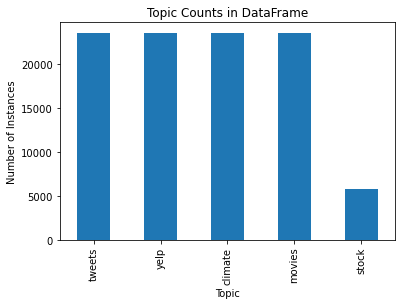

In [27]:
df['source'].value_counts().plot(kind='bar')
plt.xlabel('Topic')
plt.ylabel('Number of Instances')
plt.title('Topic Counts in DataFrame')

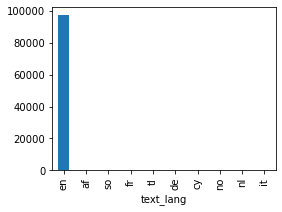

In [10]:
def detect_textlang(text):
    try:
        src_lang = detect(text)
        if src_lang =='en':
            return 'en'
        else:  
            return src_lang
    except:
        return "NA"
df['text_lang']=df..apply(detect_textlang)
plt.figure(figsize=(4,3))
df.groupby(df.text_lang).text.count().sort_values(ascending=True).head(10).plot.bar()
plt.show()

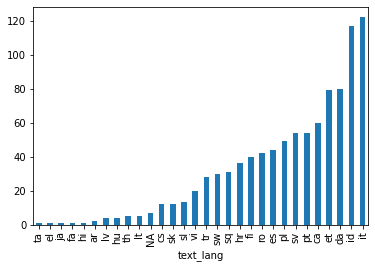

In [15]:
df.groupby(df.text_lang).text.count().sort_values(ascending=True).head(30).plot.bar()
plt.show()

In [11]:
df.groupby(df.text_lang).text.count()

text_lang
NA        7
af      334
ar        2
ca       60
cs       12
cy      170
da       80
de      204
el        1
en    97278
es       44
et       79
fa        1
fi       40
fr      246
hi        1
hr       36
hu        4
id      117
it      122
ja        1
lt        5
lv        4
nl      158
no      164
pl       49
pt       54
ro       42
sk       12
sl       13
so      282
sq       31
sv       54
sw       30
ta        1
th        5
tl      208
tr       28
vi       20
Name: text, dtype: int64

#### Visualize the distribution of sentiments across the topics using seaborn or matplotlib library.

In [4]:
df = preprocess(df)
df = df[['clean_text','text', 'sentiment_score', 'lemma_pos', 'lemmatized_tokens', 'token_no_punc', 'source', 'sentiment']]
df.head(5)

,clean_text,text,sentiment_score,lemma_pos,lemmatized_tokens,token_no_punc,source,sentiment
0,listing to music while putting the finishing t...,listing to music while putting the finishing t...,0.004808,"[('list', 'v'), ('to', 'n'), ('music', 'n'), (...","['list', 'to', 'music', 'while', 'put', 'the',...","['list', 'to', 'music', 'while', 'put', 'the',...",tweets,positive
1,welcome to the family new pillow im going to ...,welcome to the family new pillow im going to ...,0.034722,"[('welcome', 'n'), ('to', 'n'), ('the', 'n'), ...","['welcome', 'to', 'the', 'family', 'new', 'pil...","['welcome', 'to', 'the', 'family', 'new', 'pil...",tweets,positive
2,their salad is my favorite! mmmmmmm...,Their salad is my favorite! Mmmmmmm...,0.031250,"[('their', 'n'), ('salad', 'n'), ('be', 'v'), ...","['their', 'salad', 'be', 'my', 'favorite', '!'...","['their', 'salad', 'be', 'my', 'favorite', 'mm...",yelp,positive
3,bac out 11.78 waiting for a pullback.. if we h...,BAC Out 11.78 waiting for a pullback.. if we h...,0.025000,"[('bac', 'n'), ('out', 'r'), ('11.78', 'n'), (...","['bac', 'out', '11.78', 'wait', 'for', 'a', 'p...","['bac', 'out', '11.78', 'wait', 'for', 'a', 'p...",stock,positive
4,rt @darionavarro111: simplicity for the simple...,RT @darionavarro111: Simplicity for the simple...,0.010417,"[('rt', 'n'), ('@darionavarro111', 'n'), (':',...","['rt', '@darionavarro111', ':', 'simplicity', ...","['rt', '@darionavarro111', 'simplicity', 'for'...",climate,neutral


In [37]:
df.shape

(95799, 16)

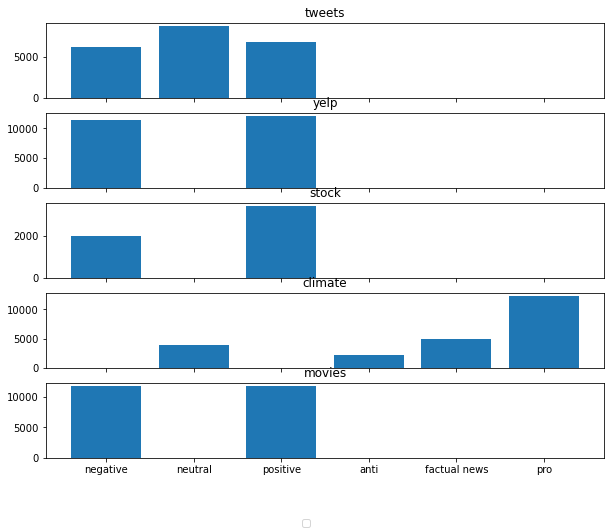

In [9]:
# group the data by topic and sentiment and get the count of each sentiment for each topic
sentiment_counts = df.groupby(['source', 'sentiment'])['lemma_pos'].count()
topics = df['source'].unique()
fig, axs = plt.subplots(len(topics), 1, figsize=(10, 8), sharex=True)

for i, topic in enumerate(topics):
    topic_counts = sentiment_counts[topic]
    axs[i].bar(topic_counts.index, topic_counts.values)
    axs[i].set_title(topic)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels))

plt.show()

In [15]:
# average length in each topic 
avg_text_len = df.groupby('source')['token_no_punc'].apply(lambda x: x.str.len().mean())
avg_text_len

source
climate     158.611250
movies     1930.210088
stock       119.146061
tweets      108.464849
yelp       1094.377036
Name: token_no_punc, dtype: float64

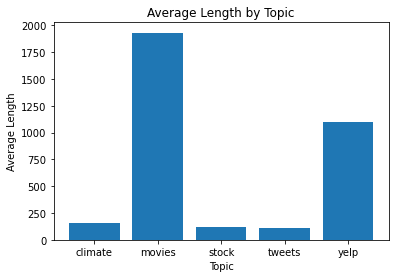

In [17]:
avg_text_len = df.groupby('source')['token_no_punc'].apply(lambda x: x.str.len().mean())
# plot histogram of average length for each topic
plt.bar(['climate', 'movies', 'stock', 'tweets', 'yelp'], avg_text_len)

# add labels and title to the chart
plt.xlabel('Topic')
plt.ylabel('Average Length')
plt.title('Average Length by Topic')

# display the chart
plt.show()

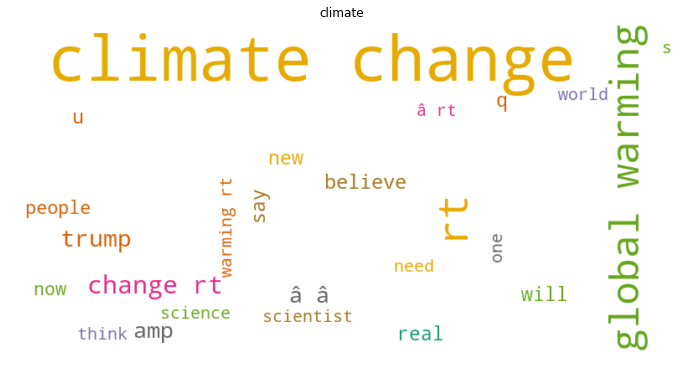

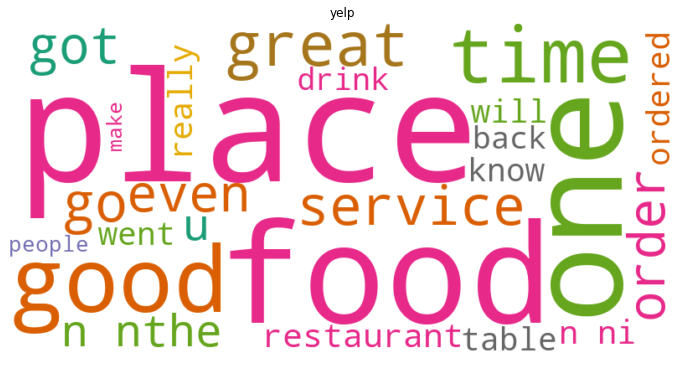

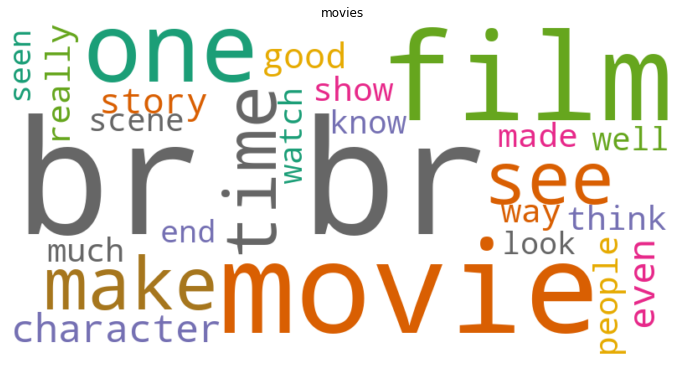

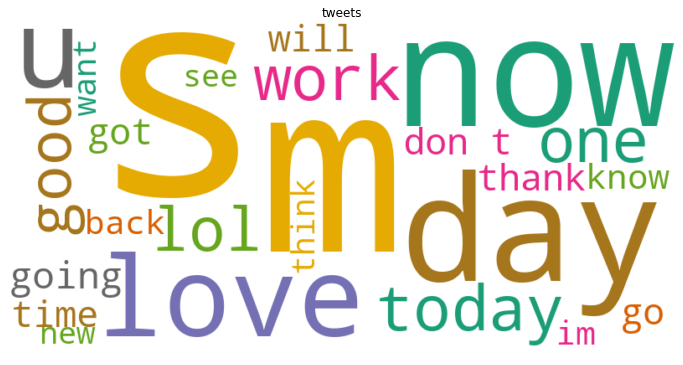

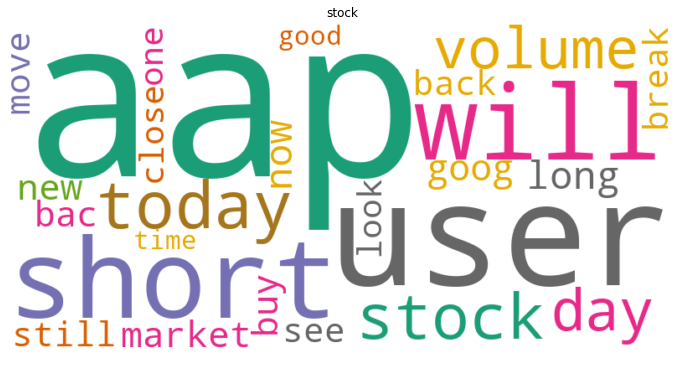

In [38]:
from wordcloud import WordCloud, STOPWORDS
# Word cloud for each topic: Display the most common words for each topic in separate word clouds. This can help 
# identify the most frequently discussed topics in the text data and the associated keywords.
stop_words = set(STOPWORDS)
grouped = df.groupby('source')
# print(stop_words)
# generate a word cloud for each topic
topics = set(df['source'])
texts_by_topic = {}
for topic in topics:
    texts_by_topic[topic] = ' '.join(df[df['source']==topic]['clean_text'])
# generate word clouds for each topic
for topic, text in texts_by_topic.items():
    wordcloud = WordCloud(stopwords=stop_words, width=800, height=400, max_words=25, background_color='white',  colormap='Dark2').generate(text)
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(topic)
    plt.show()

In [9]:
df['sentiment_score'][df['sentiment']=='negative'].describe()

count    31335.000000
mean        -0.000081
std          0.028993
min         -0.388889
25%         -0.008417
50%          0.002431
75%          0.012500
max          0.325000
Name: sentiment_score, dtype: float64

In [10]:
df['sentiment_score'][df['sentiment']=='positive'].describe()

count    33972.000000
mean         0.025274
std          0.035239
min         -0.208333
25%          0.006881
50%          0.018792
75%          0.035377
max          0.583333
Name: sentiment_score, dtype: float64

In [24]:
filtered_df = df[(df['source'] == 'stock') & (df['text'].str.contains('short'))]
neg_percent = len(filtered_df[filtered_df['sentiment']=='negative'])/len(filtered_df)
print('Tweets containing token "short" that expressed negative sentiment are ' + str(round(neg_percent*100, 2)) + "%" )

Tweets containing token "short" that expressed negative sentiment are 72.73%


# Topic Classifier

In [6]:
df = pd.read_csv("eng_only.csv")
x_train, y_train_1d, x_test, y_test_1d = total_split(df)

In [8]:
X_train, X_test, vectorizer = tf_idf(df_train, df_test)
linear_svc = LinearSVC(tol=1.0, C=1.0, multi_class='ovr', class_weight='balanced', random_state=42)
linear_svc.fit(X_train, y_train_1d)
y_predict = linear_svc.predict(X_test)
print(classification_report(y_test_1d, y_predict))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4486
           1       0.99      0.99      0.99      4782
           2       0.97      0.92      0.94      1139
           3       0.94      0.97      0.96      4370
           4       0.98      0.97      0.98      4678

    accuracy                           0.98     19455
   macro avg       0.98      0.97      0.97     19455
weighted avg       0.98      0.98      0.98     19455



In [9]:
multiNB = MultinomialNB(alpha=0.1)
multiNB.fit(X_train, y_train_1d)
y_predict = multiNB.predict(X_test)
print(classification_report(y_test_1d, y_predict))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4486
           1       0.89      1.00      0.94      4782
           2       0.99      0.89      0.94      1139
           3       0.97      0.75      0.85      4370
           4       0.89      0.98      0.93      4678

    accuracy                           0.93     19455
   macro avg       0.94      0.92      0.93     19455
weighted avg       0.93      0.93      0.93     19455



In [10]:
randomForest = RandomForestClassifier(bootstrap=True, max_depth=150, min_samples_split=10, n_estimators=494, class_weight='balanced')
randomForest.fit(X_train, y_train_1d)
y_predict = randomForest.predict(X_test)
print(classification_report(y_test_1d, y_predict))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4486
           1       0.99      0.99      0.99      4782
           2       0.95      0.84      0.89      1139
           3       0.91      0.98      0.94      4370
           4       0.99      0.94      0.97      4678

    accuracy                           0.97     19455
   macro avg       0.97      0.95      0.96     19455
weighted avg       0.97      0.97      0.97     19455



In [11]:
X_train, X_test, vectorizer = bags_of_words(df_train, df_test)
linear_svc = LinearSVC(tol=1.0, C=0.1, multi_class='ovr', class_weight='balanced', random_state=42)
linear_svc.fit(X_train, y_train_1d)
y_predict = linear_svc.predict(X_test)
print(classification_report(y_test_1d, y_predict))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4486
           1       1.00      0.99      1.00      4782
           2       0.96      0.89      0.93      1139
           3       0.94      0.98      0.96      4370
           4       0.99      0.97      0.98      4678

    accuracy                           0.98     19455
   macro avg       0.98      0.97      0.97     19455
weighted avg       0.98      0.98      0.98     19455



In [12]:
multiNB = MultinomialNB(alpha=0.1)
multiNB.fit(X_train, y_train_1d)
y_predict = multiNB.predict(X_test)
print(classification_report(y_test_1d, y_predict))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4486
           1       0.92      1.00      0.96      4782
           2       0.98      0.94      0.96      1139
           3       0.98      0.79      0.87      4370
           4       0.90      0.98      0.94      4678

    accuracy                           0.94     19455
   macro avg       0.95      0.94      0.94     19455
weighted avg       0.95      0.94      0.94     19455



In [13]:
randomForest = RandomForestClassifier(bootstrap=True, max_depth=150, min_samples_split=10, n_estimators=494, class_weight='balanced')
randomForest.fit(X_train, y_train_1d)
y_predict = randomForest.predict(X_test)
print(classification_report(y_test_1d, y_predict))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4486
           1       0.99      0.99      0.99      4782
           2       0.95      0.83      0.89      1139
           3       0.90      0.99      0.94      4370
           4       0.99      0.94      0.96      4678

    accuracy                           0.97     19455
   macro avg       0.97      0.95      0.96     19455
weighted avg       0.97      0.97      0.97     19455



## Dimension reduction (chi square vs build-in TF-IDF feature limit)

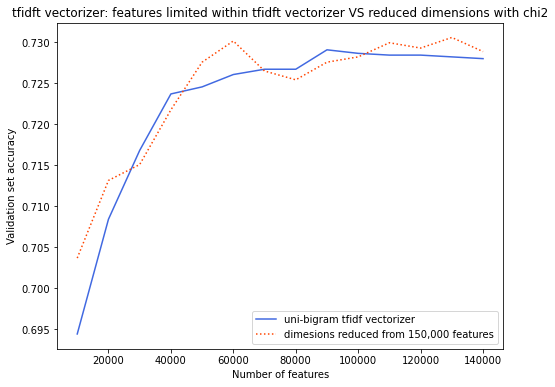

In [5]:
x_train, x_test, y_climate_train, y_climate_test, y_climate_train_1d, y_climate_test_1d, tvec = split_x_y_train_test_per_topic(1, topics, df)
ch2_result = []
tvec = TfidfVectorizer(ngram_range=(1, 2))
x_train = tvec.fit_transform(df_climate_train['lemma_pos'])
x_test = tvec.transform(df_climate_test['lemma_pos'])
chi2score = chi2(x_train, y_climate_train)[0]
for n in np.arange(10000,150000,10000):
    ch2 = SelectKBest(chi2, k=n)
    x_train_chi2_selected = ch2.fit_transform(x_train, y_climate_train_1d)
    x_test_chi2_selected = ch2.transform(x_test)
    clf = LinearSVC(class_weight='balanced', multi_class='ovr', random_state=42)
    clf.fit(x_train_chi2_selected, y_climate_train_1d)
    score = clf.score(x_test_chi2_selected, y_climate_test_1d)
    ch2_result.append(score)

    bigram_result = []
for n in np.arange(10000,150000,10000):
    tvec = TfidfVectorizer(max_features=n, ngram_range=(1, 2))
    x_train = tvec.fit_transform(df_climate_train['lemma_pos'])
    x_test = tvec.transform(df_climate_test['lemma_pos'])
    
    clf = LinearSVC(class_weight='balanced', multi_class='ovr', random_state=42)
    clf.fit(x_train, y_climate_train_1d)
    score = clf.score(x_test, y_climate_test_1d)
    bigram_result.append(score)

plt.figure(figsize=(8,6))
plt.plot(np.arange(10000,150000,10000), bigram_result,label='uni-bigram tfidf vectorizer',color='royalblue')
plt.plot(np.arange(10000,150000,10000), ch2_result,label='dimesions reduced from 150,000 features',linestyle=':', color='orangered')

plt.title("tfidft vectorizer: features limited within tfidft vectorizer VS reduced dimensions with chi2")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

### Feature Extraction Technique Comparison

In [5]:
x_train, x_test, y_climate_train, y_climate_test, y_climate_train_1d, y_climate_test_1d, tvec = split_x_y_train_test_per_topic(1, topics, df)
chi2score = chi2(x_train, y_climate_train_1d)[0]
ch2 = SelectKBest(chi2, k=130000)
x_train_chi2_selected = ch2.fit_transform(x_train, y_climate_train_1d)
x_test_chi2_selected = ch2.transform(x_test)


# unigram + bigram
clf = LinearSVC(class_weight='balanced', multi_class='ovr', random_state=42)
clf.fit(x_train_chi2_selected, y_climate_train_1d)
s=clf.score(x_test_chi2_selected, y_climate_test_1d)
print("The model using features unigram + bigram: " + str(s))

# sentiment_score + unigram + bigram
scaler = StandardScaler()
sent_score_train = scaler.fit_transform(df_climate_train['sentiment_score'].values.reshape(-1, 1))
sent_score_test = scaler.transform(df_climate_test['sentiment_score'].values.reshape(-1, 1))
X_climate_train_with_sent = hstack((sent_score_train, x_train_chi2_selected))
X_climate_test_with_sent = hstack((sent_score_test, x_test_chi2_selected))
clf = LinearSVC(class_weight='balanced', multi_class='ovr', random_state=42)
clf.fit(X_climate_train_with_sent, y_climate_train_1d)
s=clf.score(X_climate_test_with_sent, y_climate_test_1d)
print("The model using features sentiment_score + unigram + bigram: " + str(s))

# sentiment_score
clf = LinearSVC(class_weight='balanced', multi_class='ovr', random_state=42)
clf.fit(df_climate_train['sentiment_score'].values.reshape(-1, 1), y_climate_train_1d)
s=clf.score(df_climate_test['sentiment_score'].values.reshape(-1, 1), y_climate_test_1d)
print("The model using feature sentiment_score alone: " + str(s))

# unigram 
tvec = TfidfVectorizer(ngram_range=(1, 1))
x_train = tvec.fit_transform(df_climate_train['token_no_punc'])
x_test = tvec.transform(df_climate_test['token_no_punc'])

chi2score = chi2(x_train, y_climate_train_1d)[0]
optimal_k = find_optimal_k(x_train, y_climate_train_1d, x_test, y_climate_test_1d)
ch2 = SelectKBest(chi2, k=optimal_k)
x_train_chi2_selected = ch2.fit_transform(x_train, y_climate_train_1d)
x_test_chi2_selected = ch2.transform(x_test)
clf = LinearSVC(class_weight='balanced', multi_class='ovr', random_state=42)
clf.fit(x_train_chi2_selected, y_climate_train_1d)
s=clf.score(x_test_chi2_selected, y_climate_test_1d)
print("The model using feature unigram alone: " + str(s))


# bigram 
tvec = TfidfVectorizer(ngram_range=(2, 2))
x_train = tvec.fit_transform(df_climate_train['token_no_punc'])
x_test = tvec.transform(df_climate_test['token_no_punc'])

chi2score = chi2(x_train, y_climate_train_1d)[0]
optimal_k = find_optimal_k(x_train, y_climate_train_1d, x_test, y_climate_test_1d)
ch2 = SelectKBest(chi2, k=optimal_k)
x_train_chi2_selected = ch2.fit_transform(x_train, y_climate_train_1d)
x_test_chi2_selected = ch2.transform(x_test)
clf = LinearSVC(class_weight='balanced', multi_class='ovr', random_state=42)
clf.fit(x_train_chi2_selected, y_climate_train_1d)
s=clf.score(x_test_chi2_selected, y_climate_test_1d)
print("The model using feature bigram alone: " + str(s))


The model using features unigram + bigram: 0.7306034482758621
The model using features sentiment_score + unigram + bigram: 0.7303879310344827
The model using feature sentiment_score alone: 0.5010775862068966
The model using feature unigram alone: 0.7066810344827587
The model using feature bigram alone: 0.697198275862069


## Train SVC classifier for each topic with chi-square + unigram + bigram

The best k is: 130000
The best k is: 290000
The best k is: 260000
The best k is: 10000
The best k is: 10000


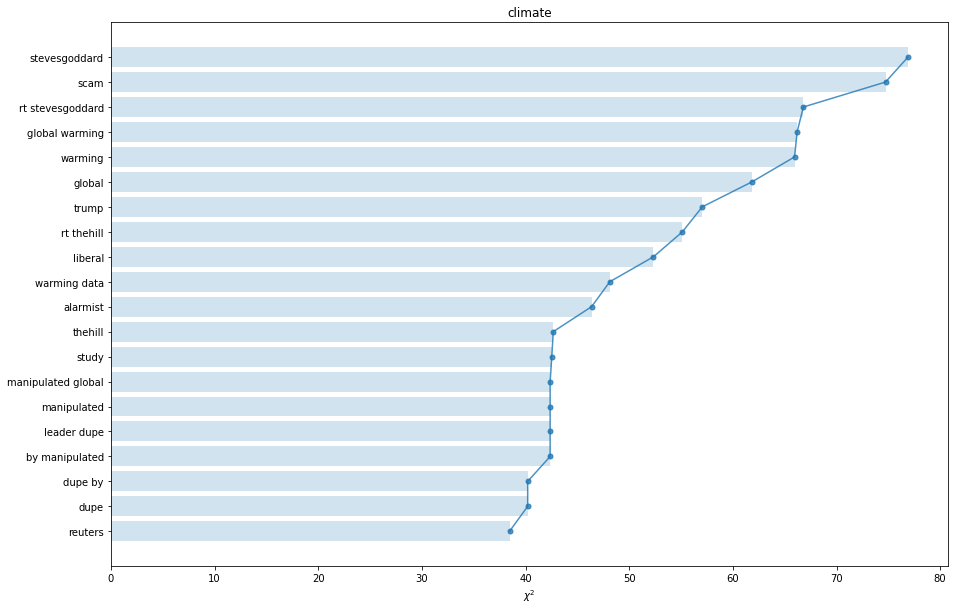

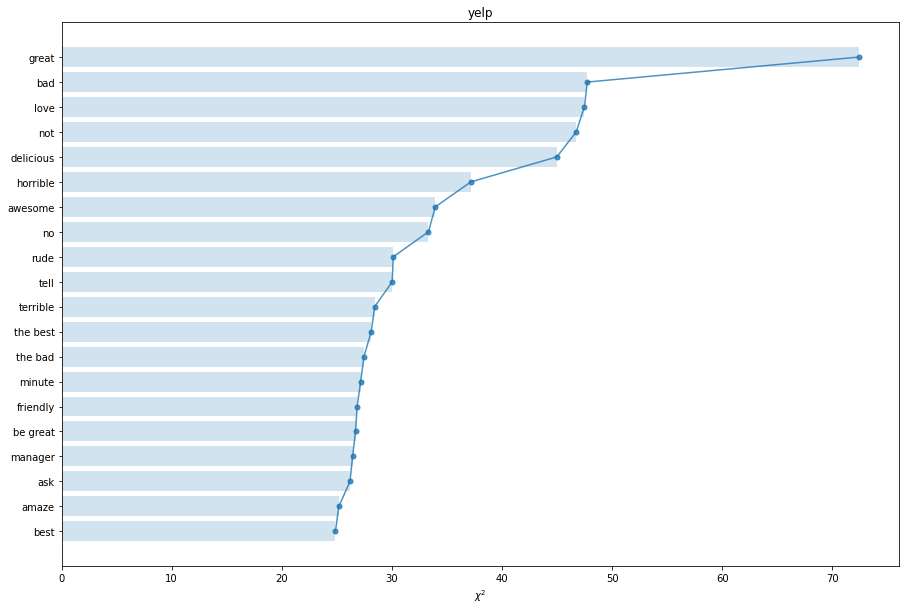

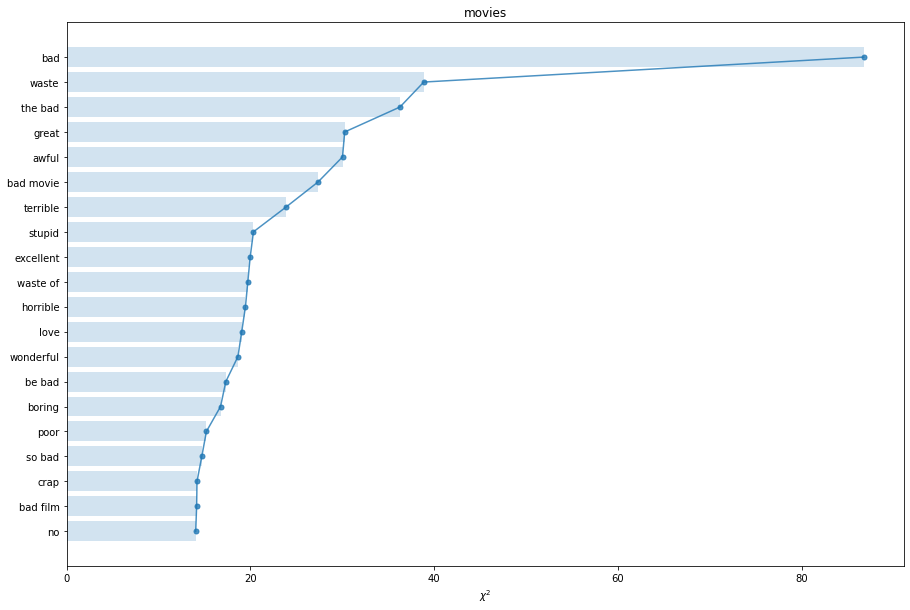

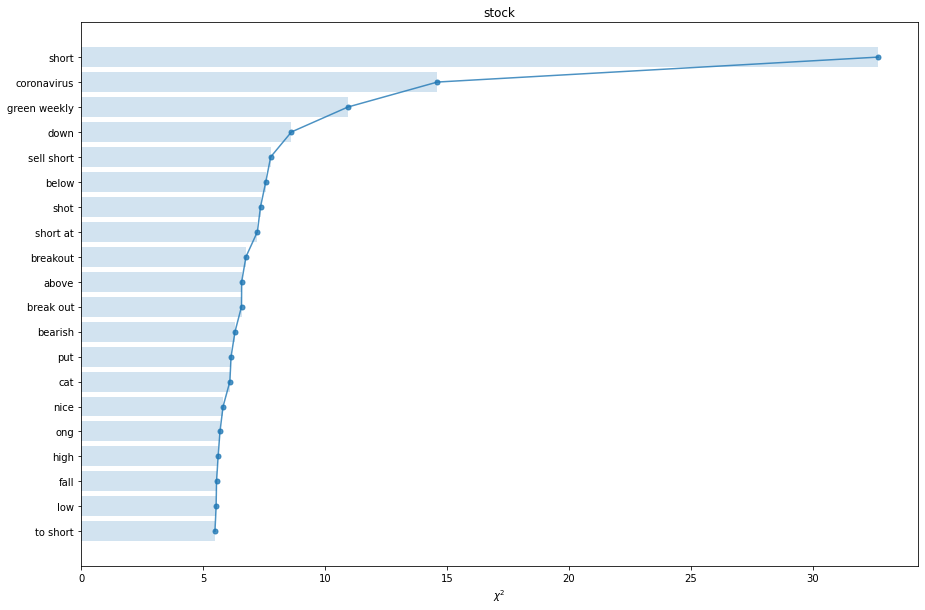

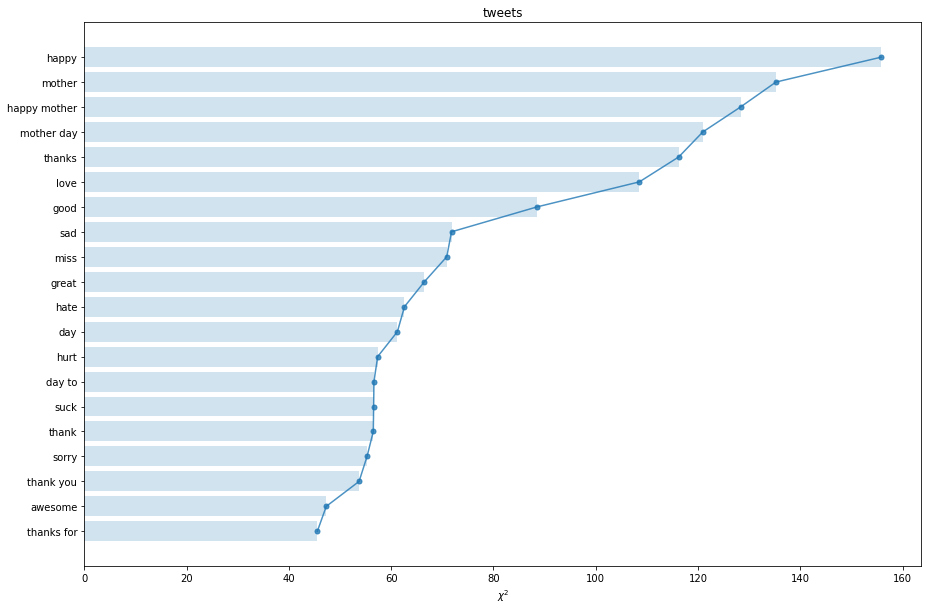

In [6]:
for i in range(1,6):    
    x_train, x_test, y_train, y_test, y_train_1d, y_test_1d, tvec = split_x_y_train_test_per_topic(i, topics, df)
    chi2score = chi2(x_train, y_train)[0]
    plt.figure(figsize=(15,10))
    wscores = zip(tvec.get_feature_names_out(), chi2score)
    wchi2 = sorted(wscores, key=lambda x:x[1])
    topchi2 = list(zip(*wchi2[-20:]))
    x = range(len(topchi2[1]))
    labels = topchi2[0]
    plt.title(topics[i])
    plt.barh(x,topchi2[1], align='center', alpha=0.2)
    plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
    plt.yticks(x, labels)
    plt.xlabel('$\chi^2$')
    k_optimal = find_optimal_k(x_train, y_train_1d, x_test, y_test_1d)  

    print("The best k is: " + str(k_optimal))


## Train Naive Bayes, SVM, Random Forest with chisqaure + bigram + unigram + sentiment score

In [7]:
topics ={1:'climate', 2: 'yelp', 3:'movies', 4:'stock', 5:'tweets'}
optimal_k ={1:130000, 2:290000, 3:260000, 4:10000, 5:10000}

for i in range(1,6):
    # prepare data
    x_train, x_test, y_train, y_test, y_train_1d, y_test_1d, tvec = split_x_y_train_test_per_topic(i, topics, df)
    ch2 = SelectKBest(chi2, k=optimal_k[i])
    x_train_chi2_selected = ch2.fit_transform(x_train, y_train_1d)
    x_test_chi2_selected = ch2.transform(x_test)
    
    print("-------------------------------------------------------------------------------------------")
    print("Training NB classifier for " + topics[i])
    best_para = grid_search_multinomialNB(x_train_chi2_selected, y_train_1d)
    print("Hyperparameters selected: " + str(best_para))
    model1 = MultinomialNB(**best_para)
    model1.fit(x_train_chi2_selected, y_train_1d)
    performance_score = model1.score(x_test_chi2_selected, y_test_1d)
    print("The performance of this classifier is " + str(performance_score))
    
    print("------------------WITHOUT CHI2-----------------")
    print("Training NB classifier for " + topics[i])
    best_para = grid_search_multinomialNB(x_train, y_train_1d)
    print("Hyperparameters selected: " + str(best_para))
    model1 = MultinomialNB(**best_para)
    model1.fit(x_train, y_train_1d)
    performance_score = model1.score(x_test, y_test_1d)
    print("The performance of this classifier is " + str(performance_score))

    print("-------------------------------------------------------------------------------------------")
    print("Training SVM classifier for " + topics[i])
    best_para =  grid_search_SVC(x_train_chi2_selected, y_train_1d)
    print("Hyperparameters selected: " + str(best_para))
    model2 = LinearSVC(**best_para)
    model2.fit(x_train_chi2_selected, y_train_1d)
    performance_score = model2.score(x_test_chi2_selected, y_test_1d)
    print("The performance of this classifier is " + str(performance_score))
    
    print("------------------WITHOUT CHI2-----------------")
    print("Training SVM classifier for " + topics[i])
    best_para = grid_search_SVC(x_train, y_train_1d)
    print("Hyperparameters selected: " + str(best_para))
    model2 = LinearSVC(**best_para)
    model2.fit(x_train, y_train_1d)
    performance_score = model2.score(x_test, y_test_1d)
    print("The performance of this classifier is " + str(performance_score))

    
    

-------------------------------------------------------------------------------------------
Training NB classifier for climate
Hyperparameters selected: {'alpha': 0.1}
The performance of this classifier is 0.6648339060710194
------------------WITHOUT CHI2-----------------
Training NB classifier for climate
Hyperparameters selected: {'alpha': 0.1}
The performance of this classifier is 0.665750286368843
-------------------------------------------------------------------------------------------
Training SVM classifier for climate
Hyperparameters selected: {'tol': 0.1, 'C': 1.0}
The performance of this classifier is 0.715922107674685
------------------WITHOUT CHI2-----------------
Training SVM classifier for climate
Hyperparameters selected: {'tol': 1.0, 'C': 1.0}
The performance of this classifier is 0.7175257731958763
-------------------------------------------------------------------------------------------
Training NB classifier for yelp
Hyperparameters selected: {'alpha': 0.0001}
The 

## Pipeline for method 1

In [ ]:
def preprocess_input_text(text):
    text = text.str.lower()
    text = re.sub(r"https?\S+", '', text)
    tknzr = TweetTokenizer()
    text = text.apply(tknzr.tokenize)
    return text

In [74]:
dfpd.read_csv("eng_only.csv")

,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,text,source,sentiment,clean_text,tokens_with_punc,lemmatized_tokens,lemma_pos,token_no_punc,language,sentiment_score
0,0,0,0,0,0,0,listing to music while putting the finishing t...,tweets,positive,listing to music while putting the finishing t...,"['listing', 'to', 'music', 'while', 'putting',...","['list', 'to', 'music', 'while', 'put', 'the',...","[('list', 'v'), ('to', 'n'), ('music', 'n'), (...","['list', 'to', 'music', 'while', 'put', 'the',...",en,0.004808
1,1,1,1,1,1,1,welcome to the family new pillow im going to ...,tweets,positive,welcome to the family new pillow im going to ...,"['welcome', 'to', 'the', 'family', 'new', 'pil...","['welcome', 'to', 'the', 'family', 'new', 'pil...","[('welcome', 'n'), ('to', 'n'), ('the', 'n'), ...","['welcome', 'to', 'the', 'family', 'new', 'pil...",en,0.034722
2,2,2,2,2,2,2,Their salad is my favorite! Mmmmmmm...,yelp,positive,their salad is my favorite! mmmmmmm...,"['their', 'salad', 'is', 'my', 'favorite', '!'...","['their', 'salad', 'be', 'my', 'favorite', '!'...","[('their', 'n'), ('salad', 'n'), ('be', 'v'), ...","['their', 'salad', 'be', 'my', 'favorite', 'mm...",en,0.031250
3,3,3,3,3,3,3,BAC Out 11.78 waiting for a pullback.. if we h...,stock,positive,bac out 11.78 waiting for a pullback.. if we h...,"['bac', 'out', '11.78', 'waiting', 'for', 'a',...","['bac', 'out', '11.78', 'wait', 'for', 'a', 'p...","[('bac', 'n'), ('out', 'r'), ('11.78', 'n'), (...","['bac', 'out', '11.78', 'wait', 'for', 'a', 'p...",en,0.025000
4,4,4,4,4,4,4,RT @darionavarro111: Simplicity for the simple...,climate,neutral,rt @darionavarro111: simplicity for the simple...,"['rt', '@darionavarro111', ':', 'simplicity', ...","['rt', '@darionavarro111', ':', 'simplicity', ...","[('rt', 'n'), ('@darionavarro111', 'n'), (':',...","['rt', '@darionavarro111', 'simplicity', 'for'...",en,0.010417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95794,97266,97266,97266,99994,99995,99995,I am very interested in animal children and I ...,movies,negative,i am very interested in animal children and i ...,"['i', 'am', 'very', 'interested', 'in', 'anima...","['i', 'be', 'very', 'interested', 'in', 'anima...","[('i', 'n'), ('be', 'v'), ('very', 'r'), ('int...","['i', 'be', 'very', 'interested', 'in', 'anima...",en,-0.011864
95795,97267,97267,97267,99995,99996,99996,: i know i*m late but i didn`t had internet....,tweets,neutral,: i know i*m late but i didn`t had internet....,"[':', 'i', 'know', 'i', '*', 'm', 'late', 'but...","[':', 'i', 'know', 'i', '*', 'm', 'late', 'but...","[(':', 'n'), ('i', 'n'), ('know', 'v'), ('i', ...","['i', 'know', 'i', 'm', 'late', 'but', 'i', 'd...",en,0.038043
95796,97268,97268,97268,99996,99997,99997,I can't wait to visit my parents in Vegas agai...,yelp,positive,i can't wait to visit my parents in vegas agai...,"['i', ""can't"", 'wait', 'to', 'visit', 'my', 'p...","['i', ""can't"", 'wait', 'to', 'visit', 'my', 'p...","[('i', 'n'), (""can't"", 'v'), ('wait', 'n'), ('...","['i', ""can't"", 'wait', 'to', 'visit', 'my', 'p...",en,0.031746
95797,97269,97269,97269,99997,99998,99998,"Very nice setup, great food and service And ve...",yelp,positive,"very nice setup, great food and service and ve...","['very', 'nice', 'setup', ',', 'great', 'food'...","['very', 'nice', 'setup', ',', 'great', 'food'...","[('very', 'r'), ('nice', 'a'), ('setup', 'n'),...","['very', 'nice', 'setup', 'great', 'food', 'an...",en,0.105769


In [28]:
topics = {0: 'climate', 1: 'movies', 2: 'stock', 3: 'tweets', 4: 'yelp'}
hyper_para = {0: {'C': 1.0, 'tol': 0.0001}, 1:{'C': 10, 'tol': 1.0}, 2:{'C': 1.0, 'tol': 0.01}, 3:{'C': 1.0, 'tol': 0.1}, 4:{'C': 10, 'tol': 0.1}}
optimal_k ={0:130000, 1:260000, 2:10000, 3:10000, 4:290000}
tvec_list = {}
models ={}
chi2_list = {}
encoder_map = {}
# topic classifier
df = pd.read_csv("eng_only.csv")
x_train_total, y_train_1d_total, x_test_total, y_test_1d_total, df_train_total, df_test_test = total_split(df)
number_test = len(y_test_1d_total)
topic_classifier = LinearSVC(tol=1.0, C=0.1, multi_class='ovr', class_weight='balanced', random_state=42)
topic_classifier.fit(x_train_total, y_train_1d_total)
topics_predicted = topic_classifier.predict(x_test_total)

# sentiment classifier

for i in range(0,5):
    # prepare data
    x_train, x_test, y_train, y_test, y_train_1d, y_test_1d, tvec, mapping = split_x_y_train_test_per_topic(i, topics, df)
    tvec_list[i] = tvec
    ch2 = SelectKBest(chi2, k=optimal_k[i])
    x_train_chi2_selected = ch2.fit_transform(x_train, y_train_1d)
    x_test_chi2_selected = ch2.transform(x_test)
    chi2_list[i]=ch2
    model = LinearSVC(class_weight='balanced', **hyper_para[i])
    model.fit(x_train_chi2_selected, y_train_1d)
    models[i] = model
    encoder_map[i] = mapping 

In [8]:
correct = 0
print(number_test)
for i in range(0, number_test):
    topic = topics_predicted[i]
    feature = tvec_list[topic].transform([df_test_test['token_no_punc'].iloc[i]])
    feature_reduced_text = chi2_list[topic].transform(feature)
    sent_predicted = models[topic].predict(feature_reduced_text)[0]
    if df_test_test['sentiment'].iloc[i]==encoder_map[topic][sent_predicted]:
        correct += 1
print(correct/number_test)

19160
0.9238517745302715


## Method 2: Single Classifier with Combined Labels

In [3]:
df = pd.read_csv("eng_only.csv")
target = np.asarray([s + '_' + t for s, t in zip(df['source'], df['sentiment'])])
print("target combined...")
encoder = OneHotEncoder()
target_encoded = encoder.fit_transform(target.reshape(-1, 1)).toarray()
x_train, x_test, y_train, y_test = train_test_split(df['token_no_punc'], target_encoded, test_size=0.2, random_state=42)
y_train_1d = np.argmax(y_train, axis=1)
y_test_1d = np.argmax(y_test, axis=1)
tvec = TfidfVectorizer(ngram_range=(1, 2))
x_train = tvec.fit_transform(x_train)
x_test = tvec.transform(x_test)
mapping = dict(zip(range(len(encoder.categories_[0])), encoder.categories_[0]))
print("The corresponding label:")
print(mapping)
print(y_train_1d)
print("Data ready...")
optimal_k = find_optimal_k(x_train, y_train_1d, x_test, y_test_1d)
print("Optimal K is: " + str(optimal_k))
ch2 = SelectKBest(chi2, k=optimal_k)
x_train_chi2_selected = ch2.fit_transform(x_train, y_train_1d)
x_test_chi2_selected = ch2.transform(x_test)
    
print("---------------------------------------------Mutinomial NB----------------------------------------------------")
print("Training NB classifier....")
best_para = grid_search_multinomialNB(x_train_chi2_selected, y_train_1d)
print("Hyperparameters selected: " + str(best_para))
model1 = MultinomialNB(**best_para)
model1.fit(x_train_chi2_selected, y_train_1d)
performance_score = model1.score(x_test_chi2_selected, y_test_1d)
print("The performance of this classifier is " + str(performance_score))

print("------------------WITHOUT CHI2-----------------")
print("Training NB classifier....")
best_para = grid_search_multinomialNB(x_train, y_train_1d)
print("Hyperparameters selected: " + str(best_para))
model1 = MultinomialNB(**best_para)
model1.fit(x_train, y_train_1d)
performance_score = model1.score(x_test, y_test_1d)
print("The performance of this classifier is " + str(performance_score))

print("---------------------------------------------SVM----------------------------------------------------")
print("Training SVM classifier...")
best_para =  grid_search_SVC(x_train_chi2_selected, y_train_1d)
print("Hyperparameters selected: " + str(best_para))
model2 = LinearSVC(**best_para)
model2.fit(x_train_chi2_selected, y_train_1d)
performance_score = model2.score(x_test_chi2_selected, y_test_1d)
print("The performance of this classifier is " + str(performance_score))

print("------------------WITHOUT CHI2-----------------")
print("Training SVM classifier...")
best_para = grid_search_SVC(x_train, y_train_1d)
print("Hyperparameters selected: " + str(best_para))
model2 = LinearSVC(**best_para)
model2.fit(x_train, y_train_1d)
performance_score = model2.score(x_test, y_test_1d)
print("The performance of this classifier is " + str(performance_score))


target combined...
The corresponding label:
{0: 'climate_anti', 1: 'climate_factual news', 2: 'climate_neutral', 3: 'climate_pro', 4: 'movies_negative', 5: 'movies_positive', 6: 'stock_negative', 7: 'stock_positive', 8: 'tweets_negative', 9: 'tweets_neutral', 10: 'tweets_positive', 11: 'yelp_negative', 12: 'yelp_positive'}
[10  1  2 ...  5  4  4]
Data ready...
Optimal K is: 1400000
---------------------------------------------Mutinomial NB----------------------------------------------------
Training NB classifier....
Hyperparameters selected: {'alpha': 0.001}
The performance of this classifier is 0.6911795407098121
------------------WITHOUT CHI2-----------------
Training NB classifier....
Hyperparameters selected: {'alpha': 0.001}
The performance of this classifier is 0.692223382045929
---------------------------------------------SVM----------------------------------------------------
Training SVM classifier...
Hyperparameters selected: {'tol': 0.01, 'C': 1}
The performance of this cla

## External Text Testing

In [ ]:
#------------------Climate
# factual news
t1 ="NASA's latest report shows that the year 2020 tied with 2016 as the warmest year on record. The report highlights the urgent need for climate action to prevent further warming and its devastating impacts on the planet. #climatechange #NASA"
t2 = "According to a recent study, sea levels could rise by up to 2.4 meters by 2100 if the world fails to curb greenhouse gas emissions. The findings underscore the importance of urgent and ambitious climate action. #climatechange #sealevelrise #study"
# pro opinion
t3 = "We have a responsibility to protect our planet for future generations. Taking action on climate change is not only necessary, but it's also an opportunity to create a healthier, more equitable, and sustainable world for all."
t4 = "The science is clear - climate change is real, and it's happening now. But there's still time to act. By investing in clean energy, sustainable agriculture, and green infrastructure, we can build a resilient and prosperous future for our planet. #ClimateAction #GreenRecovery"
# anti opinion
t5 = "climate change is a scam."
t6 = "climate change is just a myth."
# neutral 
t7 = "The debate on climate change continues, but there's no denying the importance of protecting our planet and working towards a sustainable future. Let's continue to educate ourselves on the issue and take responsible action. #climatechange #sustainability"

#------------------Stock
# pos
t8 = "The stock market has been on a steady rise lately, with many companies reporting strong earnings and growth prospects. It's an exciting time for investors, and a testament to the strength of our economy. #stockmarket #investing #economy"
t9 ="Despite the recent volatility in the market, many experts remain optimistic about the long-term prospects of the stock market. With the right strategy and a long-term outlook, investors can still achieve their financial goals. #stockmarket #investing #longterm"
# neg
t10 = "The stock market is unpredictable and volatile, with many investors experiencing significant losses in recent months. It's a stark reminder that investing always carries risk, and it's important to be cautious and diversified. #stockmarket #investing #risk"
t11 = "The stock market has become detached from the reality of the economy, with many companies reporting record profits despite ongoing economic hardship for many Americans. It's a reminder of the systemic inequalities that exist in our financial system. #stockmarket #inequality #economy"

#------------------Miscellanous tweet
# pos
t12 = "Kindness is contagious! By spreading positivity and compassion, we can make the world a better place. Let's all do our part to lift each other up and create a brighter future. #kindness #positivity #spreadlove"
t13 = "The power of education is immeasurable. By investing in education, we can unlock the potential of individuals and communities, and create a more prosperous and equitable world. #education #empowerment #future"
# neg 
t14 = "It's frustrating to see the lack of progress on important issues like climate change and social justice. But we can't give up hope. We must keep pushing for change and fighting for what's right. #frustrated #changeneeded #socialjustice"
t15 = "Misinformation and fake news are running rampant on social media, causing harm and dividing communities. We must be vigilant in our consumption of information and fact-check everything we see. #fakenews #misinformation #factcheck"
# neutral
t16 = "The weather today is mild and sunny, with a chance of rain later in the afternoon. It's a good day to get outside and enjoy the fresh air. #weather #outdoors #sunny"
t17 = "Technology continues to advance at a rapid pace, with new innovations and developments changing the way we live and work. It's an exciting time to be alive, and there's so much potential for the future. #technology #innovation #future"


#------------------Yelp
# pos
t18 ="I had an amazing experience at this restaurant! The food was delicious, the service was impeccable, and the atmosphere was cozy and inviting. I highly recommend trying the pasta dish - it was to die for! #yelpreview #restaurantreview #foodie"
t19 ="I recently visited this spa and it was a total dream. The massage was so relaxing, the amenities were luxurious, and the staff went above and beyond to make sure I was comfortable and taken care of. I left feeling refreshed and rejuvenated. #yelpreview #spareview #relaxation"
# neg
t20 = "I had a terrible experience at this salon. The stylist didn't listen to what I wanted, the haircut was uneven, and the prices were way too high for the quality of service. I left feeling frustrated and disappointed. #yelpreview #salonreview #badexperience"
t21 = "I had high hopes for this hotel, but it fell short in every way. The room was dirty and outdated, the staff was unfriendly, and the amenities were subpar. I would not recommend staying here. #yelpreview #hotelreview #disappointing"

#------------------Movies
# pos
t22="I just watched the new superhero movie, and I have to say it was amazing! The action scenes were thrilling, the characters were well-developed, and the storyline was engaging from start to finish. I highly recommend this movie to anyone who loves a good action flick. #movies #superheroes #action"
t23= "I recently saw the new romantic comedy, and it was everything I hoped it would be. The actors had great chemistry, the humor was on point, and the message of the movie was uplifting and heartwarming. It's the perfect feel-good movie for a night in. #movies #romanticcomedy #feelgood"
# neg
t24 = "I was really disappointed with the latest horror movie. The scares were predictable, the characters were one-dimensional, and the storyline was unoriginal. It's a shame because I had high hopes for this movie, but it just fell flat. #movies #horror #disappointed"
t25="I recently watched the new drama movie, and it left me feeling empty and unsatisfied. The pacing was slow, the characters were unlikable, and the themes were heavy-handed. It's a movie that tries too hard to be profound but ultimately fails to deliver. #movies #drama #unsatisfied"

In [21]:
test = [t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20,t21,t22,t23]
sentiment = []

for i in test:
    input_text = i
    text_standardized = pre_process(input_text)
    predicted_topic = topic_classifier.predict(BoW.transform(text_standardized)) # use training topic classifier to prdict the topic first
    feature_extracted = tvec_list[predicted_topic].transform(input_text) # extract features beased on the topic predicted
    feature_reduced = chi2_list[topic].transform(feature_extracted) # reduce features based on the topic predicted
    predicted_sentiment = models[predicted_topic].predict(feature_reduced)[0] # predict sentiment using the topic-specific classifier
    sentiment.append(encoder_map[predicted_topic][predicted_sentiment])
print(predicted_sentiment)

['factual news', 'factual news', 'pro', 'pro', 'anti', 'anti', 'pro', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'negative', 'negative', 'positive', 'neutral', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'negative', 'negative']
